# Factor Analysis

Mixture models are limited, since they only use a single hidden (also called 'latent') variable to generate the observations; each of the possible prototypes are mutually exclusive (see `expectation_maximization_GMM.ipynb` for a demonstration of a Gaussian mixture model). An alternative to mixture models is to use a _vector_ of real-valued latent variables, $\mathbf{z}_i\in \mathbb{R}^L$, for continuous observations $\mathbf{x}_i \in \mathbb{R}^D$.

For example, we may use a Gaussian prior on the latent variables

$$p(\mathbf{z}_i)=\mathcal{N}(\mathbf{z}_i|\boldsymbol{\mu}_0,\mathbf{\Sigma}_0)$$

and assume that the data are distributed such that the mean of the data is a linear function of the latent variables

$$p(\mathbf{x}_i|\mathbf{z}_i,\boldsymbol{\theta})=\mathcal{N}(\mathbf{W z_i + \boldsymbol{\mu}, \Psi}).$$

When $\Psi$ is a diagonal matrix, we call this factor analysis. When $\Psi = \sigma I$, we call this probabilistic principal component analysis.

Based on Chapter 12 of Murphy, Machine Learning: A Probabilistic Perspective and Chapter 21 of Barber, Bayesian Reasoning and Machine Learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utls 
import scipy.stats as ss
import seaborn as sns

In [2]:
sns.reset_orig()

In [3]:
utls.reset_plots()

In [4]:
%matplotlib inline

## Factor analysis as a means to define a density on $\mathbf{x}$

First, we will take $\Psi=\sigma \mathbf{I}$. This is called *probabilistic principal component analysis* (PPCA). Let $L=1$ and $D=2$.

In [5]:
mu0 = 0
sigma0 = 1
z = np.random.normal(mu0,sigma0,5000) # latent variables
w = np.array([5,7]) # factor loading matrix (D x L)
mu = np.array([-1,1]) # centre
sigma = 3*np.eye(2) # this is constrained to be a diagonal matrix in general
x = np.array([np.random.multivariate_normal(zi*w+mu, sigma) for zi in z])

In [6]:
z_space = np.linspace(-3,3)

Get density of a particular $z_i$

In [7]:
zi=2
p_zi = ss.norm.pdf(zi,mu0,sigma0)

X1_zi = zi*w[0] + mu[0] + np.linspace(-2,2)
X2_zi = zi*w[1] + mu[1] + np.linspace(-2,2)
X1_zi, X2_zi = np.meshgrid(X1_zi,X2_zi)
pos = np.empty(X1_zi.shape + (2,))
pos[:, :, 0] = X1_zi
pos[:, :, 1] = X2_zi
zi_density = utls.multivariate_gaussian(pos, mu=zi*w+mu, Sigma=sigma)

Plot the density generated by the PPCA

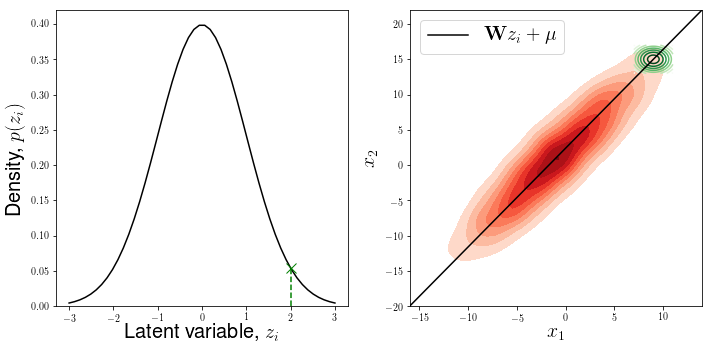

In [8]:
fig, axs = plt.subplots(1,2,figsize=(2*5,5))
axs = axs.ravel()

ax = axs[0]
ax.plot(z_space, ss.norm.pdf(z_space,mu0,sigma0),'-k')
ax.plot(zi, p_zi, 'gx')
ax.plot(np.ones(50)*zi, np.linspace(0,p_zi),'--g')
ax.set_xlabel('Latent variable, $z_i$')
ax.set_ylabel('Density, $p(z_i)$')
ax.set_ylim([0,0.42])

ax = axs[1]
k1 = sns.kdeplot(x[:,0],x[:,1],cmap="Reds",shade=True,shade_lowest=False,ax=ax)
ax.contour(X1_zi, X2_zi, zi_density, cmap='Greens')
ax.plot(w[0]*z_space+mu[0],w[1]*z_space+mu[1],'-k', label="$\mathbf{W}z_i+\mathbf{\mu}$")
ax.legend(prop={'size':20})
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([-3*w[0]+mu[0],3*w[0]+mu[0]])
ax.set_ylim([-3*w[1]+mu[1],3*w[1]+mu[1]])
plt.tight_layout()

Left: Showing the probability density over the latent variable $z_i$. The green cross corresponds to a particular value of the latent variable: in this case $z_i = 2$

Right: Showing the resultant probability density generated on the space $(x_1,x_2)$ in red. The black line corresponds to the line of mean values each tuple $(x_1,x_2)$ can take. The green density shows the probability density of $\mathbf{x}$ given that $z_i = 2$. It is in this sense that we can consider PPCA as taking an isotropic Gaussian "spray can" over the line $\mathbf{W}z_i+\mathbf{\mu}$, resulting in an elongated (and hence correlated) Gaussian in 2D space.
When the green distribution is an ellipse, this is called factor analysis.

Factor analysis only uses $\mathcal{O}(LD)$ parameters, allowing flexible compromise between a full covariance Gaussian, with $\mathcal{O}(D^2)$ parameters, and a diagonal covariance, with $\mathcal{O}(D)$ parameters (where $L \leq D)$. Hence, factor analysis is a low-rank parametrization of a multivariate-normal.

## Bayesian inference of scores in factor analysis

We wish to fit a factor analysis model to a dataset of car data. Each row will be a different make of car, and the vertical axes will be different real-valued features.

In [9]:
import pandas as pd

In [10]:
d = pd.read_csv('../Data/04cars/04cars-fixed.csv')
d.head()

,Sports,SUV,Wagon,Minivan,Pickup,AWD,RWD,Retail,Dealer,Engine,Cylinders,Horsepower,CityMPG,HighwayMPG,Weight,Wheelbase,Length,Width
Acura 3.5 RL,0,0,0,0,0,0,0,43755,39014,3.5,6,225,18,24,3880,115,197,72
Acura 3.5 RL Navigation,0,0,0,0,0,0,0,46100,41100,3.5,6,225,18,24,3893,115,197,72
Acura MDX,0,1,0,0,0,1,0,36945,33337,3.5,6,265,17,23,4451,106,189,77
Acura NSX S,1,0,0,0,0,0,1,89765,79978,3.2,6,290,17,24,3153,100,174,71
Acura RSX,0,0,0,0,0,0,0,23820,21761,2.0,4,200,24,31,2778,101,172,68


Strip out binary variables for this demo

In [11]:
d = d.iloc[:,7:]

In [12]:
d.head()

,Retail,Dealer,Engine,Cylinders,Horsepower,CityMPG,HighwayMPG,Weight,Wheelbase,Length,Width
Acura 3.5 RL,43755,39014,3.5,6,225,18,24,3880,115,197,72
Acura 3.5 RL Navigation,46100,41100,3.5,6,225,18,24,3893,115,197,72
Acura MDX,36945,33337,3.5,6,265,17,23,4451,106,189,77
Acura NSX S,89765,79978,3.2,6,290,17,24,3153,100,174,71
Acura RSX,23820,21761,2.0,4,200,24,31,2778,101,172,68


In [13]:
d.shape

(387, 11)

So we have 387 rows (cars) and 11 features

In [14]:
d_norm = (d - d.mean())/d.std(ddof = 1) # z-transform data

In [15]:
d_norm.reset_index(inplace=True)
d_norm.rename_axis({'index':'Name'}, axis="columns",inplace=True)

In [16]:
d_norm.head()

,Name,Retail,Dealer,Engine,Cylinders,Horsepower,CityMPG,HighwayMPG,Weight,Wheelbase,Length,Width
0,Acura 3.5 RL,0.533537,0.478926,0.367351,0.162996,0.150230,-0.439475,-0.579057,0.492267,1.098999,0.909409,0.214799
1,Acura 3.5 RL Navigation,0.652424,0.595455,0.367351,0.162996,0.150230,-0.439475,-0.579057,0.510681,1.098999,0.909409,0.214799
2,Acura MDX,0.188283,0.161796,0.367351,0.162996,0.719521,-0.629504,-0.756487,1.301045,-0.171012,0.305088,1.699215
3,Acura NSX S,2.866153,2.767267,0.071585,0.162996,1.075328,-0.629504,-0.579057,-0.537472,-1.017686,-0.828013,-0.082084
4,Acura RSX,-0.477128,-0.484865,-1.111480,-1.179122,-0.205577,0.700704,0.662958,-1.068631,-0.876574,-0.979094,-0.972733


### Fit an $L=2$ dimensional factor analysis model

The posterior over latent factors is (see Murphy, p385 & 389)

$$p(\mathbf{z}_i|x_i,\mathbf{\theta}) = \mathcal{N}(\mathbf{z}_i|\mathbf{m}_i,\mathbf{\Sigma_i})$$

$$\mathbf{\Sigma_i}:=(I_L+\mathbf{W}^T\mathbf{\Psi}^{-1}\mathbf{W})^{-1}$$

$$\mathbf{m}_i:=\mathbf{\Sigma}_i(\mathbf{W}^T\mathbf{\Psi}^{-1}(\mathbf{x}_i-\boldsymbol{\mu}))$$

where $I_L$ is an $L\times L$ identity matrix and $\mathbf{\Psi}$ is of the form
$$\mathbf{\Psi}=\text{diag}(\psi_1,\dots,\psi_D)$$
(as opposed to the more restrictive PPCA model $\mathbf{\Psi}=\sigma^2 I$)

![](Figures/FA.svg)

The isotropic Gaussian prior means that the latent variables do not directly influence each other.

Use `scikit-learn` which implements Expectation Maximization to find the maximum-likelihood values of $\mathbf{W}$ and $\mathbf{\Psi}$. $\boldsymbol{\mu}$ is simply the mean of the data, which is $\mathbf{0}$ since we have z-transformed the data. Uses Algorithm 21.1 of Barber, Bayesian Reasoning and Machine Learning.

In [17]:
D = 11 # number of features
L = 2 # Dimension of the reduced-dimension space

In [18]:
from sklearn.decomposition import FactorAnalysis

In [19]:
f =FactorAnalysis(n_components=L)

In [20]:
X = d_norm.iloc[:,1:].as_matrix()

In [21]:
m = f.fit_transform(X) # fit model, and transform data, returning the means of the latent variables

In [22]:
m_scaled = m*0.1 # scale down the amplitudes of the scores, for plotting

In [23]:
feat_names = d_norm.columns

In [24]:
f.components_.shape

(2, 11)

In [25]:
m.shape

(387, 2)

Find the extreme cars in each basis to plot

In [26]:
sort_cars = m_scaled.argsort(axis=0)
max_x = sort_cars[:3]
min_x = sort_cars[-3:,:]
extreme_indicies = np.unique(np.ravel(np.vstack((max_x, min_x))))

In [27]:
cars_names = d_norm.Name

Make a biplot. This is where we take each feature and project them into the low-dimensional space: this is simply plotting each component of the weight matrix $\mathbf{W}$. We also the data in this space.

(-0.6, 1.2)

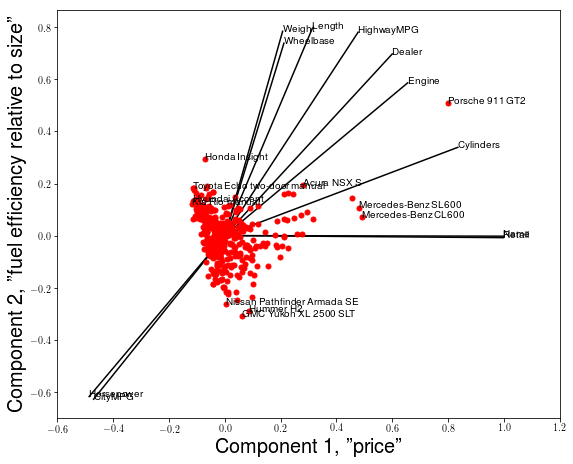

In [28]:
fig, ax = plt.subplots(1,1,figsize=(9,7.5))
for i in range(D):
    c1=f.components_[0,i]
    c2=-f.components_[1,i] # invert this axis 
    ax.plot([0,c1],[0,c2],'-k')
    ax.annotate(feat_names[i],(c1,c2))
plt.plot(m_scaled[:,0],m_scaled[:,1],'.r')

for c in extreme_indicies:   
    ax.annotate(d_norm.loc[c].Name,m_scaled[c,:])
        
    

ax.set_xlabel('Component 1, "price"')
ax.set_ylabel('Component 2, "fuel efficiency relative to size"')
ax.set_xlim([-0.6,1.2])

The features "Retail" and "Dealer" align with Component 1, being a pseudo measure of price. Component 2 places heavy, less efficient, vehicles higher than light, efficient vehicles, so it is a pseudo mea. However, in general, interpreting latent variable models is fraught with difficulties.